In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import Ridge, Lasso, LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, cross_validate, ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
rnafold = pd.read_csv('datasets/rnacofold.csv')
rnafold['sequence'] = rnafold['crRNA'] + rnafold['tracrRNA']
#rnafold = rnafold[['sequence', 'fluo_8h']]
rnafold

,c_index,crRNA,t_index,tracrRNA,MFE_structures,MFE,free_energy_thermodynamic_ensemble,frequency_MFR_structures,delta_G,GC_content,GC_7bp,percent_match_no_spacer,percent_match_with_spacer,fluo_8h,homology,sequence
0,c1,agcagggaacagacu,t1,agucuguAAGUccugcU,(((((((.((((((.&.))))))...))))))),18.2,19.29,17.13080,-18.80,53.3,42.9,33,74,68759.32,60.0000,agcagggaacagacuagucuguAAGUccugcU
1,c2,gaucgguaaaaguua,t2,uaacuuuAAGUccgauU,((((((..((((((.&.))))))....)))))),-9.9,11.05,15.39140,-10.94,33.3,14.3,50,76,23483.95,53.3333,gaucgguaaaaguuauaacuuuAAGUccgauU
2,c4,aaauguauuuaaaga,t4,ucuuuaaAAGUacauuU,((((((((((((((.&.))))))..)))))))),-9.1,10.87,5.64016,-10.81,13.3,14.3,29,71,814.91,46.6667,aaauguauuuaaagaucuuuaaAAGUacauuU
3,c5,auucacaugaauccu,t5,aggauucAAGUgugaaU,((((((((((((((.&.)))))))..))))))),15.6,17.14,8.23581,-15.10,33.3,42.9,27,65,67539.29,46.6667,auucacaugaauccuaggauucAAGUgugaaU
4,c6,uacguaccgggugaa,t6,uucacccAAGUuacguU,.(((((..((((((.&.))))))....))))).,13.9,15.12,13.73120,-14.60,53.3,57.1,23,71,55101.14,60.0000,uacguaccgggugaauucacccAAGUuacguU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,c89,gguaggaaggcaucc,t89,ggaugccAAGUccuacU,(((((((.((((((.&.))))))...))))))),19.1,21.63,1.65823,-17.26,60.0,71.4,37,75,70345.84,53.3333,gguaggaaggcauccggaugccAAGUccuacU
86,c90,ccgucgcgagccuau,t90,auaggcuAAGUcgacgU,.(((((..((((((.&.))))))....))))).,15.5,17.29,5.43777,-16.76,66.7,42.9,43,77,20478.49,46.6667,ccgucgcgagccuauauaggcuAAGUcgacgU
87,c91,gcauucgaguggcaa,t91,uugccacAAGUgaaugU,(((((((.((((((.&.))))))...))))))),16.4,17.02,36.84490,-15.83,53.3,57.1,40,74,65102.68,46.6667,gcauucgaguggcaauugccacAAGUgaaugU
88,c92,uagucaacuaggggu,t92,accccuaAAGUugacuU,.(((((((((((((.&.)))))..)))))))).,19.2,20.48,12.45000,-20.15,46.7,57.1,26,64,54328.28,66.6667,uagucaacuagggguaccccuaAAGUugacuU


In [3]:
eng_feats = ['MFE', 'free_energy_thermodynamic_ensemble', 'frequency_MFR_structures', 'delta_G', \
           'GC_content', 'GC_7bp', 'percent_match_no_spacer', 'percent_match_with_spacer', 'homology']

def getKmers(sequence, size=3):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

rnafold['words'] = rnafold.apply(lambda x: getKmers(x['sequence']), axis=1)

texts = list(rnafold['words'])
for item in range(len(texts)):
    texts[item] = ' '.join(texts[item])

cv = CountVectorizer(ngram_range=(2, 2))

X_seq_only = cv.fit_transform(texts)
X_complete = pd.concat([pd.DataFrame(X_seq_only.toarray()), rnafold[eng_feats]], axis=1)
X_no_seq = rnafold[eng_feats]
y = rnafold['fluo_8h']
#y_cat = to_categorical(pd.qcut(y, 3, labels=False))

### Classical Machine Learning

#### Regression with sequence-only features

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_seq_only, y, test_size=0.2)

regressors = [
    ('Linear Regressor', LinearRegression()),
    ('Ridge Regressor', Ridge()),
    ('Lasso Regressor', Lasso()),
    #('SGD Regressor', SGDRegressor()),
    ('k Nearest Neighbors', KNeighborsRegressor()),
    ('Decision Tree', DecisionTreeRegressor()),
    ('Linear SVM', SVR(kernel='linear')),
    ('RBF Regressor', SVR(kernel='rbf')),
    ('Random Forest', RandomForestRegressor()),
    ('Gradient Boosting', RandomForestRegressor()),
    ('Neural Network (MLP)', MLPRegressor())
]
results = []
for regressor in tqdm(regressors):
    cv_results = cross_validate(regressor[1], X_seq_only, y, cv=5, scoring=('r2', 'neg_mean_squared_error'))
    rmse = ([np.sqrt(i) for i in (cv_results['test_neg_mean_squared_error'] * -1)]) 
    for m in rmse:
        results.append(('Sequence only', regressor[0], m))

for regressor in tqdm(regressors):
    cv_results = cross_validate(regressor[1], X_complete, y, cv=5, scoring=('r2', 'neg_mean_squared_error'))
    rmse = ([np.sqrt(i) for i in (cv_results['test_neg_mean_squared_error'] * -1)])
    for m in rmse:
        results.append(('Sequence + engineered features', regressor[0], m))
        
for regressor in tqdm(regressors):
    cv_results = cross_validate(regressor[1], X_no_seq, y, cv=5, scoring=('r2', 'neg_mean_squared_error'))
    rmse = ([np.sqrt(i) for i in (cv_results['test_neg_mean_squared_error'] * -1)]) 
    for m in rmse:
        results.append(('Engineered features', regressor[0], m))
    
perf = pd.DataFrame(results, columns=['Features', 'Model', 'RMSE'])
perf

100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


,Features,Model,RMSE
0,Sequence only,Linear Regressor,31656.458593
1,Sequence only,Linear Regressor,26921.338470
2,Sequence only,Linear Regressor,22883.114272
3,Sequence only,Linear Regressor,21196.742505
4,Sequence only,Linear Regressor,25869.648036
...,...,...,...
145,Engineered features,Neural Network (MLP),47152.793709
146,Engineered features,Neural Network (MLP),43767.722533
147,Engineered features,Neural Network (MLP),40126.376667
148,Engineered features,Neural Network (MLP),49187.203004


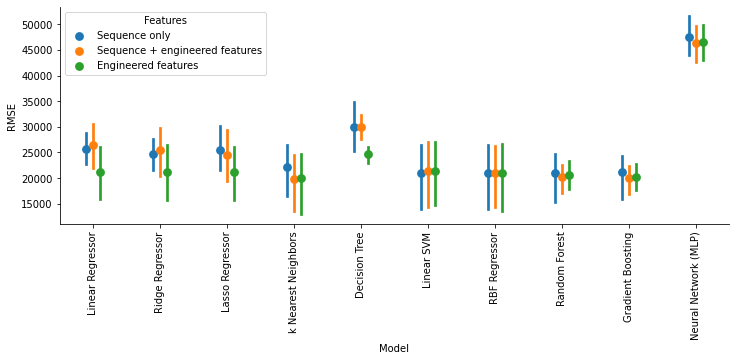

In [5]:
plt.figure(figsize=[12, 4])
sns.pointplot(data=perf, x='Model', y='RMSE', hue='Features', dodge=0.2, join=False)
plt.xticks(rotation=90)
plt.ylabel('RMSE')
sns.despine()
plt.show()

100%|██████████| 10/10 [00:01<00:00,  9.33it/s]


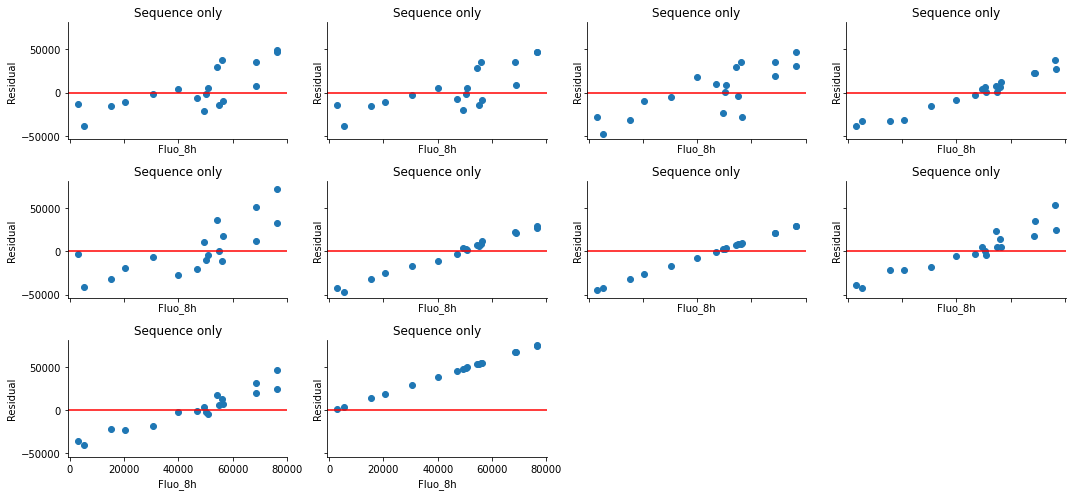

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_complete, y, test_size=0.2, random_state=42)
#print(X_train.shape, X_test.shape)

results1 = []
for regressor in tqdm(regressors):
    regressor[1].fit(X_train, y_train)
    y_pred = regressor[1].predict(X_test)
    results1.append((regressor[0], y_test, (y_test - y_pred)))
    
f, axs = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(15, 7))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < 10:
        ax.scatter(results1[i][1], results1[i][2])
        ax.axhline(y=0, color='r', linestyle='-')
        ax.set_title(results[i][0])
        #plt.xticks(rotation=90)
        ax.set_xlabel('Fluo_8h')
        ax.set_ylabel('Residual')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

#### Hyperparameters tuning

In [8]:
params = {
    'kmers': [2, 3, 4, 5],
    'ngram_low': [1, 2],
    'ngram_up': [3, 4] 
}

best_params_all = []
for regressor in tqdm(regressors):
    
    perf = []
    grid = ParameterGrid(params)
    for g in grid:

        df = rnafold[['sequence', 'fluo_8h']]
        df['words'] = df.apply(lambda x: getKmers(x['sequence'], g['kmers']), axis=1)

        texts = list(df['words'])
        for item in range(len(texts)):
            texts[item] = ' '.join(texts[item])
        cv = CountVectorizer(ngram_range=(g['ngram_low'], g['ngram_up']))
        X_seq_only = cv.fit_transform(texts)
        X_complete = pd.concat([pd.DataFrame(X_seq_only.toarray()), rnafold[eng_feats]], axis=1)
        X_no_seq = rnafold[eng_feats]
        y = rnafold['fluo_8h']

        X_train, X_test, y_train, y_test = train_test_split(X_complete, y, test_size=0.20, random_state=42)

        regressor[1].fit(X_train, y_train)
        y_pred = regressor[1].predict(X_test)
        perf.append(mean_squared_error(y_test, y_pred))

    best_idx = perf.index(max(perf))
    best_params = (list(grid))[best_idx]
    best_params_all.append((regressor[0], regressor[1], best_params))
    
best_params_all

100%|██████████| 10/10 [02:12<00:00, 13.21s/it]


[('Linear Regressor',
  LinearRegression(),
  {'kmers': 2, 'ngram_low': 1, 'ngram_up': 3}),
 ('Ridge Regressor', Ridge(), {'kmers': 2, 'ngram_low': 1, 'ngram_up': 3}),
 ('Lasso Regressor', Lasso(), {'kmers': 2, 'ngram_low': 2, 'ngram_up': 3}),
 ('k Nearest Neighbors',
  KNeighborsRegressor(),
  {'kmers': 2, 'ngram_low': 2, 'ngram_up': 3}),
 ('Decision Tree',
  DecisionTreeRegressor(),
  {'kmers': 2, 'ngram_low': 1, 'ngram_up': 4}),
 ('Linear SVM',
  SVR(kernel='linear'),
  {'kmers': 5, 'ngram_low': 2, 'ngram_up': 4}),
 ('RBF Regressor', SVR(), {'kmers': 5, 'ngram_low': 2, 'ngram_up': 4}),
 ('Random Forest',
  RandomForestRegressor(),
  {'kmers': 3, 'ngram_low': 2, 'ngram_up': 4}),
 ('Gradient Boosting',
  RandomForestRegressor(),
  {'kmers': 3, 'ngram_low': 1, 'ngram_up': 4}),
 ('Neural Network (MLP)',
  MLPRegressor(),
  {'kmers': 3, 'ngram_low': 2, 'ngram_up': 4})]

100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


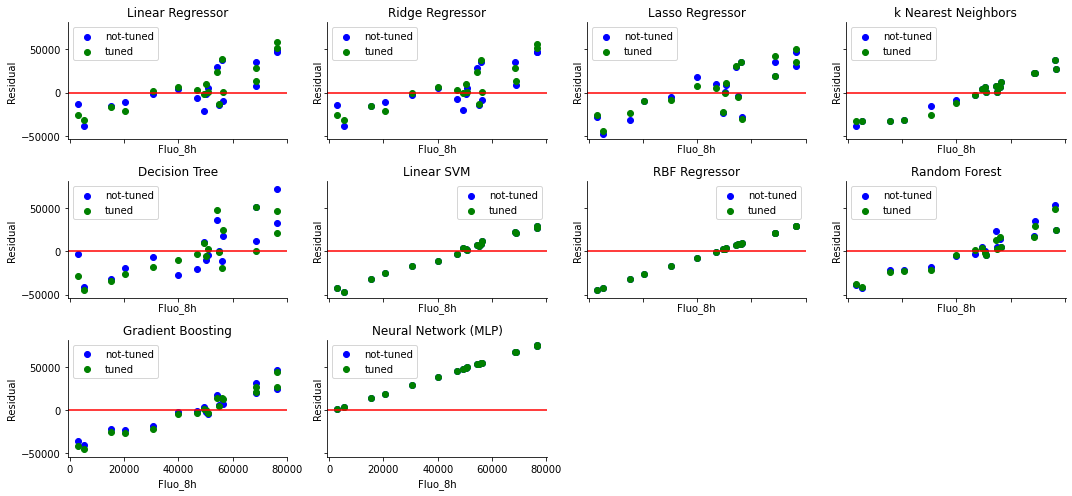

In [14]:
results2 = []
for best_params in tqdm(best_params_all):
    df = rnafold[['sequence', 'fluo_8h']]
    df['words'] = df.apply(lambda x: getKmers(x['sequence'], best_params[2]['kmers']), axis=1)

    texts = list(df['words'])
    for item in range(len(texts)):
        texts[item] = ' '.join(texts[item])
    cv = CountVectorizer(ngram_range=(best_params[2]['ngram_low'], best_params[2]['ngram_up']))
    X_seq_only = cv.fit_transform(texts)
    X_complete = pd.concat([pd.DataFrame(X_seq_only.toarray()), rnafold[eng_feats]], axis=1)
    X_no_seq = rnafold[eng_feats]
    y = rnafold['fluo_8h']

    X_train, X_test, y_train, y_test = train_test_split(X_complete, y, test_size=0.20, random_state=42)

    regressor = best_params[1]
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    results2.append((best_params[0], y_test, (y_test - y_pred)))
    
f, axs = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(15, 7))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < 10:
        ax.scatter(results1[i][1], results1[i][2], color='b', label='not-tuned')
        ax.scatter(results2[i][1], results2[i][2], color='g', label='tuned')
        ax.axhline(y=0, color='r', linestyle='-')
        ax.set_title(results1[i][0])
        #plt.xticks(rotation=90)
        ax.set_xlabel('Fluo_8h')
        ax.set_ylabel('Residual')
        ax.legend()
    else:
        ax.set_visible(False)
        

plt.tight_layout()
sns.despine()